In [143]:
import os
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

FEATURE_COLUMNS = [
    "year", "month", "intrinsic_value", "stock_exret", "stock_ticker", "comp_name", "be_me", "ni_me", "fcf_me",
    "betadown_252d", "ni_ar1", "z_score", "ebit_sale", "at_turnover",
    "market_equity", "roic", "bvps", "prev_bvps", "bvps_change", "prev_at_turnover",
    "at_turnover_change", "prev_ni_me", "ni_me_change", "prev_fcf_me", "fcf_me_change",
    "sin_month", "cos_month"
] # 27 - 4 = 23
# ignore stock_ticker, comp_name, year, month

SEQ_LENGTH = 12

In [73]:
def process_time_features(df):
    """ Remove `year`, and encode `month` cyclically """
    if "year" not in df.columns or "month" not in df.columns:
        raise KeyError("The dataset does not contain 'year' or 'month' columns.")

    df["sin_month"] = np.sin(2 * np.pi * df["month"] / 12)
    df["cos_month"] = np.cos(2 * np.pi * df["month"] / 12)
    return df
    # return df.drop(columns=["year", "month"])  # Remove original time columns

In [140]:
def normalize_features(df):
    feature_columns = [col for col in df.columns if col not in ["year", "month", "stock_exret"]]
    
    scaler = MinMaxScaler()
    df[feature_columns] = scaler.fit_transform(df[feature_columns])

    return df

In [125]:
def load_company_data(company):
    file_path = f"data/{company}.csv"

    if not os.path.exists(file_path):
        print(f"Skipping {company} (No data found)")
        return None, None

    df = pd.read_csv(file_path)

    df = df.fillna(0)  # Replace NaNs with 0
    
    df = df.drop(columns=["stock_ticker", "comp_name"], errors="ignore")
    
    # Normalize feature columns (excluding year, month, and stock_exret)
    df = normalize_features(df)
    
    if "year" not in df.columns or "month" not in df.columns:
        print(f"Skipping {company} (Missing 'year' or 'month' column)")
        return None, None

    # df = df.sort_values(by=["year", "month"]) # already sorted
    df_train = df[(df["year"] < 2023) | ((df["year"] == 2023) & (df["month"] < 12))].copy()
    df_test = df[(df["year"] == 2023) & (df["month"] == 12)].copy()

    df_train = process_time_features(df_train)
    df_test = process_time_features(df_test)

    return df_train, df_test

In [130]:
def create_lstm_sequences(df, seq_length, company_id):
    """
    Converts dataframe into LSTM sequences for training only.
    Uses a rolling window approach: each sequence consists of `seq_length` months,
    and the next month's value is the target.
    """
    X_train, Y_train, company_ids_train = [], [], []

    # df = df[df['year'] == 2022]
    df = df[df['year'].isin([2022, 2023])]

    df = df.drop(columns=['year', 'month'])

    df_values = df.values  # Convert DataFrame to numpy array
    num_samples = len(df_values)

    for i in range(num_samples - seq_length):
        x_seq = df_values[i:i + seq_length]  # Past `seq_length` months
        y_target = df_values[i + seq_length][0]  # Predict next month's `stock_exret`

        X_train.append(x_seq)
        Y_train.append(y_target)
        company_ids_train.append(company_id)

    return np.array(X_train), np.array(Y_train), np.array(company_ids_train)

In [120]:
class StockLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, num_companies, embedding_dim):
        super(StockLSTM, self).__init__()
        
        self.input_size = input_size

        # Company embedding layer
        self.embedding = nn.Embedding(num_companies, embedding_dim)

        # LSTM
        self.lstm = nn.LSTM(input_size + embedding_dim, hidden_size, num_layers, batch_first=True)

        # Fully connected output layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, company_ids):
        # Convert company IDs to embeddings
        company_embedding = self.embedding(company_ids).unsqueeze(1)  # (batch, 1, embedding_dim)
        company_embedding = company_embedding.expand(-1, x.shape[1], -1)  # Repeat across time steps

        # Concatenate embeddings with financial data
        x = torch.cat((x, company_embedding), dim=2)
        print(f"Model forward input shape: {x.shape}")  # (batch, seq_length, input_size)

        # Pass through LSTM
        lstm_out, _ = self.lstm(x)

        # Use last time step's output for prediction
        output = self.fc(lstm_out[:, -1, :])

        return output

2501
CSCO
torch.Size([18, 5, 23])
torch.Size([18, 1])
torch.Size([18])

Training on CSCO...
Model forward input shape: torch.Size([18, 5, 73])
Epoch 1/10, Train Loss: 0.910560
Model forward input shape: torch.Size([18, 5, 73])
Epoch 2/10, Train Loss: 0.780337
Model forward input shape: torch.Size([18, 5, 73])
Epoch 3/10, Train Loss: 0.661152
Model forward input shape: torch.Size([18, 5, 73])
Epoch 4/10, Train Loss: 0.550769
Model forward input shape: torch.Size([18, 5, 73])
Epoch 5/10, Train Loss: 0.447038
Model forward input shape: torch.Size([18, 5, 73])
Epoch 6/10, Train Loss: 0.348602
Model forward input shape: torch.Size([18, 5, 73])
Epoch 7/10, Train Loss: 0.255558
Model forward input shape: torch.Size([18, 5, 73])
Epoch 8/10, Train Loss: 0.169785
Model forward input shape: torch.Size([18, 5, 73])
Epoch 9/10, Train Loss: 0.095238
Model forward input shape: torch.Size([18, 5, 73])
Epoch 10/10, Train Loss: 0.038004


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([18, 1])) that is different to the input size (torch.Size([18])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


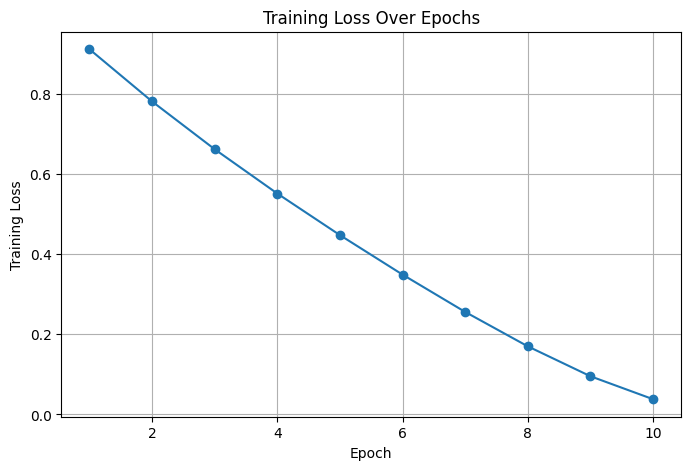

In [145]:
# Get list of companies
company_files = [f.split(".csv")[0] for f in os.listdir("data") if f.endswith(".csv")]  # 2501 companies
print(len(company_files))
company_to_id = {comp: idx for idx, comp in enumerate(company_files)}

# Model parameters
feature_input_size = len(FEATURE_COLUMNS)  # This should match actual features before embedding
embedding_dim = 50  # sqrt(num_companies)
input_size = 23  # feature_input_size(25) + embedding_dim(50) = 75

hidden_size = 64
num_layers = 2
output_size = 1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = StockLSTM(input_size, hidden_size, num_layers, output_size, len(company_files), embedding_dim).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for company in company_files:
    company_id = company_to_id[company]
    
    if company_id != 0:
        continue  # Only train on one company for now

    print(company)
    df_train, df_test = load_company_data(company)
    
    if df_train is None:
        continue  # Skip if no data

    # Create training sequences (rolling window)
    X_train_tensor, Y_train_tensor, company_train_tensor = create_lstm_sequences(df_train, 5, company_id)

    # Convert to PyTorch tensors
    X_train_tensor = torch.tensor(X_train_tensor, dtype=torch.float32)
    Y_train_tensor = torch.tensor(Y_train_tensor, dtype=torch.float32).unsqueeze(1)  # Make sure Y is (batch_size, 1)
    company_train_tensor = torch.tensor(company_train_tensor, dtype=torch.long)

    print(X_train_tensor.shape)
    print(Y_train_tensor.shape)
    print(company_train_tensor.shape)

    train_dataset = TensorDataset(X_train_tensor, company_train_tensor, Y_train_tensor)

    # Move the entire dataset to the device
    X_train_tensor, company_train_tensor, Y_train_tensor = (
        X_train_tensor.to(device),
        company_train_tensor.to(device),
        Y_train_tensor.to(device),
    )

    print(f"\nTraining on {company}...")

    # Store loss values
    train_losses = []

    num_epochs = 10
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()

        predictions = model(X_train_tensor, company_train_tensor).squeeze()
        loss = criterion(predictions, Y_train_tensor)

        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())  # Append loss for plotting

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {loss.item():.6f}")

    # Plot Loss Curve
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, num_epochs + 1), train_losses, marker='o', linestyle='-')
    plt.xlabel("Epoch")
    plt.ylabel("Training Loss")
    plt.title("Training Loss Over Epochs")
    plt.grid(True)
    plt.show()

    # train_dataset = TensorDataset(X_train_tensor, company_train_tensor, Y_train_tensor)
    # train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    # print(f"\nTraining on {company}...")

    # for epoch in range(10):
    #     model.train()
    #     total_loss = 0

    #     for batch_X, batch_company, batch_Y in train_dataloader:
    #         batch_X, batch_company, batch_Y = batch_X.to(device), batch_company.to(device), batch_Y.to(device)

    #         optimizer.zero_grad()
    #         predictions = model(batch_X, batch_company).squeeze()
    #         loss = criterion(predictions, batch_Y)
    #         loss.backward()
    #         optimizer.step()

    #         total_loss += loss.item()

    #     print(f"Epoch {epoch+1}/10, Train Loss: {total_loss / len(train_dataloader):.6f}")

In [ ]:
print(X_train_tensor.shape)
print(Y_train_tensor.shape)
print(company_train_tensor.shape)
# company_train_tensor

(7, 5, 23)
(7,)
(7,)


In [146]:
# CSCO
torch.save(model.state_dict(), "trained_stock_lstm.pth")
print("\nModel saved!")

# Testing (Predict Dec 2023 & Compare to Actual)

test_company = input("\nEnter company name for testing: ")
df_train, df_test = load_company_data(test_company)

print(df_test)

# df_test is already processed because of load_company_data

if df_test is None or df_test.empty:
    print(f" No test data available for {test_company}.")
else:
    latest_financials = df_test.iloc[-1].to_dict()

    input_df = pd.DataFrame([latest_financials], columns=FEATURE_COLUMNS)
    print(input_df)

    input_df = input_df.drop(columns=["year", "month", "stock_ticker", "comp_name"], errors="ignore")
    input_df = input_df.fillna(0)  # in case
    # input_df = normalize_features(input_df)
    
    input_tensor = torch.tensor(input_df.values, dtype=torch.float32).unsqueeze(0).to(device)

    print(input_tensor.shape)
    
    test_company_id = torch.tensor([company_to_id[test_company]], dtype=torch.long).to(device)
    
    model.eval()
    with torch.no_grad():
        predicted_return = model(input_tensor, test_company_id).item()

    actual_return = df_test["stock_exret"].values[0]

    print(f"\nPredicted: {predicted_return:.4f} | Actual: {actual_return:.4f}")


Model saved!
     year  month  intrinsic_value  stock_exret     be_me     ni_me    fcf_me  \
278  2023     12              1.0     0.039933  0.356361  0.701354  0.767614   

     betadown_252d    ni_ar1  z_score  ...  prev_bvps  bvps_change  \
278       0.047692  0.198832  0.01416  ...   0.636896      0.48847   

     prev_at_turnover  at_turnover_change  prev_ni_me  ni_me_change  \
278          0.561061            0.764575    0.605139      0.427759   

     prev_fcf_me  fcf_me_change     sin_month  cos_month  
278     0.645094       0.610768 -2.449294e-16        1.0  

[1 rows x 25 columns]
     year  month  intrinsic_value  stock_exret  stock_ticker  comp_name  \
0  2023.0   12.0              1.0     0.039933           NaN        NaN   

      be_me     ni_me    fcf_me  betadown_252d  ...  prev_bvps  bvps_change  \
0  0.356361  0.701354  0.767614       0.047692  ...   0.636896      0.48847   

   prev_at_turnover  at_turnover_change  prev_ni_me  ni_me_change  \
0          0.561061  

In [ ]:
# print("MPS Available:", torch.backends.mps.is_available())

# device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
# print("Using device:", device)
# # portion to use GPU
# print("Computation done on:", device)